In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 1. Load the Data

In [2]:
# Load the full dataset from local CSV
df = pd.read_csv('../data/hour.csv')
df['dteday'] = pd.to_datetime(df['dteday'])

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['dteday'].min()} to {df['dteday'].max()}")
print(f"\nColumns: {list(df.columns)}")
df.head()

Dataset shape: (17379, 17)
Date range: 2011-01-01 00:00:00 to 2012-12-31 00:00:00

Columns: ['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# Check data types and missing values
print("Data types:")
print(df.dtypes)
print(f"\nMissing values: {df.isnull().sum().sum()}")

Data types:
instant                int64
dteday        datetime64[ns]
season                 int64
yr                     int64
mnth                   int64
hr                     int64
holiday                int64
weekday                int64
workingday             int64
weathersit             int64
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object

Missing values: 0


In [4]:
# Split into training (2011) and evaluation (2012) sets
train_2011 = df[df['yr'] == 0].copy()
eval_2012 = df[df['yr'] == 1].copy()

print(f"Training set (2011): {len(train_2011):,} records")
print(f"Evaluation set (2012): {len(eval_2012):,} records")

Training set (2011): 8,645 records
Evaluation set (2012): 8,734 records


## 2. Exploratory Data Analysis

### 2.1 Target Variable Distribution

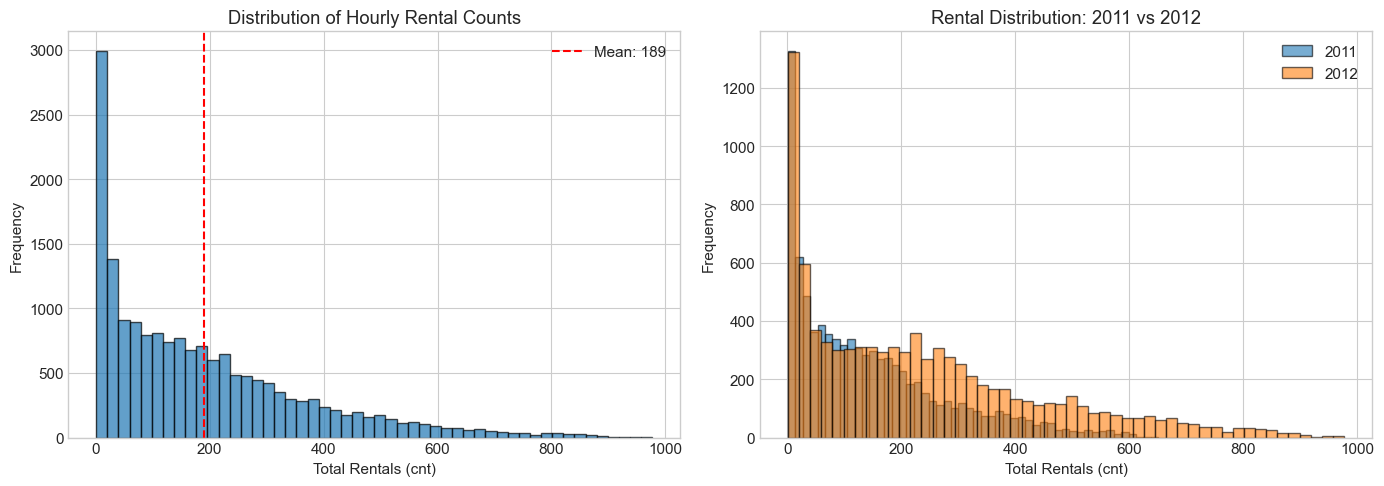

2011 mean rentals: 143.8
2012 mean rentals: 234.7
Change: 63.2%


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of rental counts
axes[0].hist(df['cnt'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Total Rentals (cnt)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Hourly Rental Counts')
axes[0].axvline(df['cnt'].mean(), color='red', linestyle='--', label=f'Mean: {df["cnt"].mean():.0f}')
axes[0].legend()

# Compare 2011 vs 2012
axes[1].hist(train_2011['cnt'], bins=50, alpha=0.6, label='2011', edgecolor='black')
axes[1].hist(eval_2012['cnt'], bins=50, alpha=0.6, label='2012', edgecolor='black')
axes[1].set_xlabel('Total Rentals (cnt)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Rental Distribution: 2011 vs 2012')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"2011 mean rentals: {train_2011['cnt'].mean():.1f}")
print(f"2012 mean rentals: {eval_2012['cnt'].mean():.1f}")
print(f"Change: {((eval_2012['cnt'].mean() / train_2011['cnt'].mean()) - 1) * 100:.1f}%")

### 2.2 Ridership Patterns by Hour

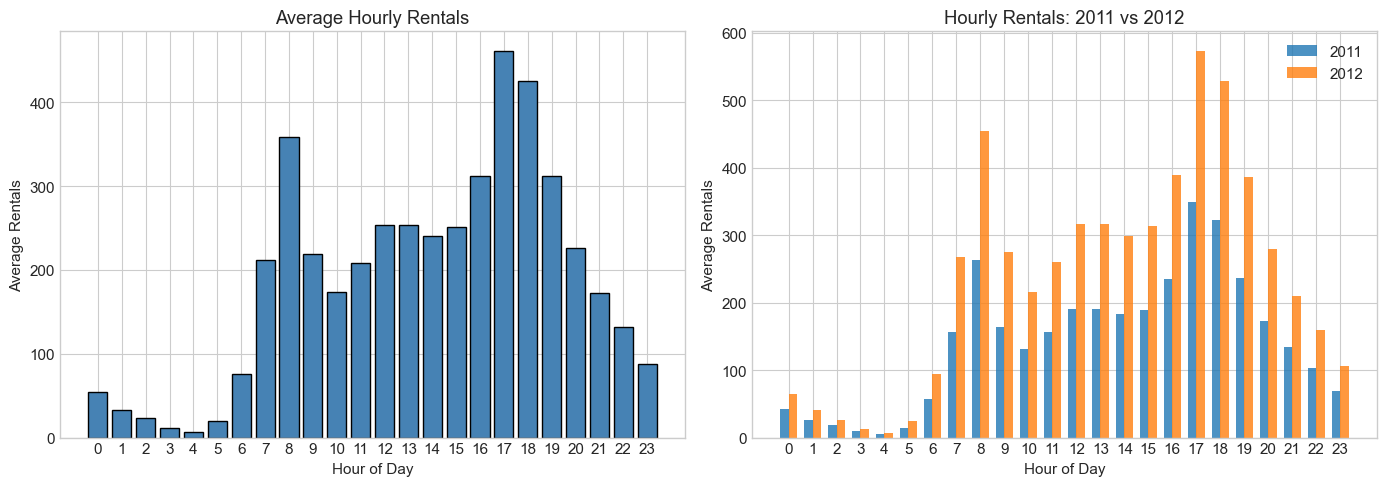

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average rentals by hour
hourly_avg = df.groupby('hr')['cnt'].mean()
axes[0].bar(hourly_avg.index, hourly_avg.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Rentals')
axes[0].set_title('Average Hourly Rentals')
axes[0].set_xticks(range(0, 24))

# Compare 2011 vs 2012 by hour
hourly_2011 = train_2011.groupby('hr')['cnt'].mean()
hourly_2012 = eval_2012.groupby('hr')['cnt'].mean()

x = np.arange(24)
width = 0.35
axes[1].bar(x - width/2, hourly_2011.values, width, label='2011', alpha=0.8)
axes[1].bar(x + width/2, hourly_2012.values, width, label='2012', alpha=0.8)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Average Rentals')
axes[1].set_title('Hourly Rentals: 2011 vs 2012')
axes[1].set_xticks(range(0, 24))
axes[1].legend()

plt.tight_layout()
plt.show()

### 2.3 Ridership Patterns by Day of Week and Workday

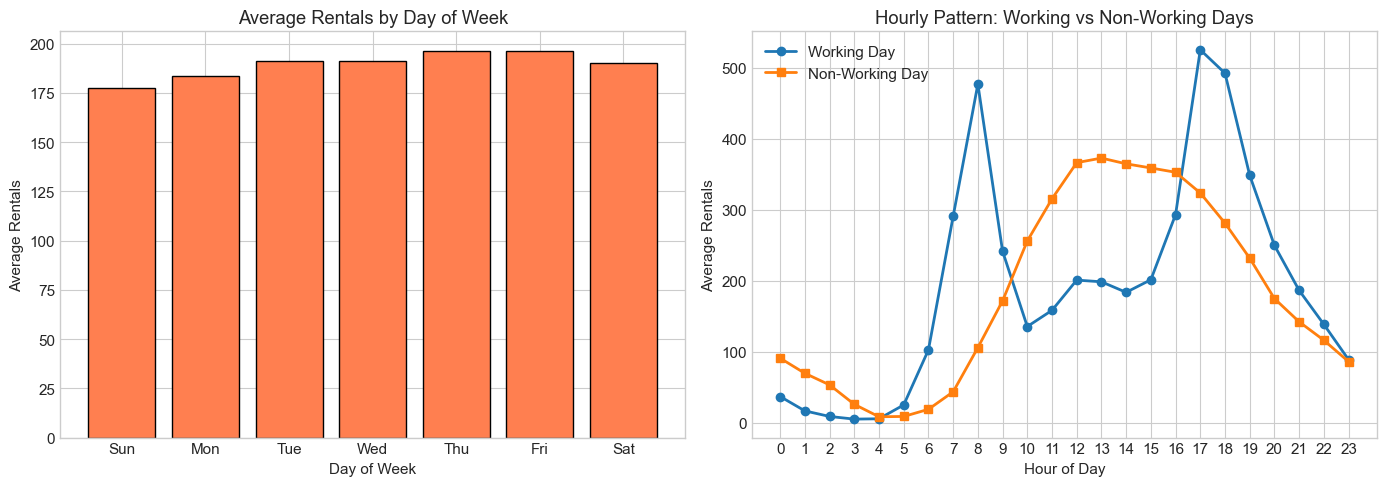

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# By day of week
day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
daily_avg = df.groupby('weekday')['cnt'].mean()
axes[0].bar(day_names, daily_avg.values, color='coral', edgecolor='black')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Rentals')
axes[0].set_title('Average Rentals by Day of Week')

# Workday vs Non-workday by hour (shows commute pattern)
workday_hourly = df[df['workingday'] == 1].groupby('hr')['cnt'].mean()
nonwork_hourly = df[df['workingday'] == 0].groupby('hr')['cnt'].mean()

axes[1].plot(workday_hourly.index, workday_hourly.values, 'o-', label='Working Day', linewidth=2)
axes[1].plot(nonwork_hourly.index, nonwork_hourly.values, 's-', label='Non-Working Day', linewidth=2)
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Average Rentals')
axes[1].set_title('Hourly Pattern: Working vs Non-Working Days')
axes[1].legend()
axes[1].set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

### 2.4 Seasonal Patterns

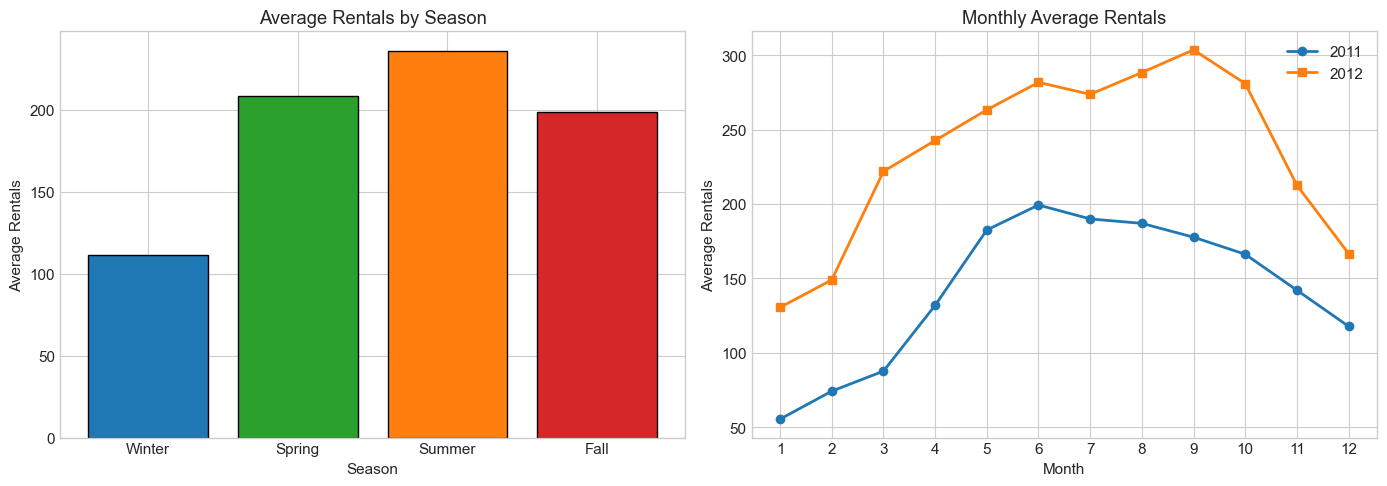

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

season_names = ['Winter', 'Spring', 'Summer', 'Fall']

# Average by season
seasonal_avg = df.groupby('season')['cnt'].mean()
colors = ['#1f77b4', '#2ca02c', '#ff7f0e', '#d62728']
axes[0].bar(season_names, seasonal_avg.values, color=colors, edgecolor='black')
axes[0].set_xlabel('Season')
axes[0].set_ylabel('Average Rentals')
axes[0].set_title('Average Rentals by Season')

# Monthly trend
monthly = df.groupby(['yr', 'mnth'])['cnt'].mean().reset_index()
monthly_2011 = monthly[monthly['yr'] == 0]
monthly_2012 = monthly[monthly['yr'] == 1]

axes[1].plot(monthly_2011['mnth'], monthly_2011['cnt'], 'o-', label='2011', linewidth=2)
axes[1].plot(monthly_2012['mnth'], monthly_2012['cnt'], 's-', label='2012', linewidth=2)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Rentals')
axes[1].set_title('Monthly Average Rentals')
axes[1].legend()
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

### 2.5 Weather Feature Distributions

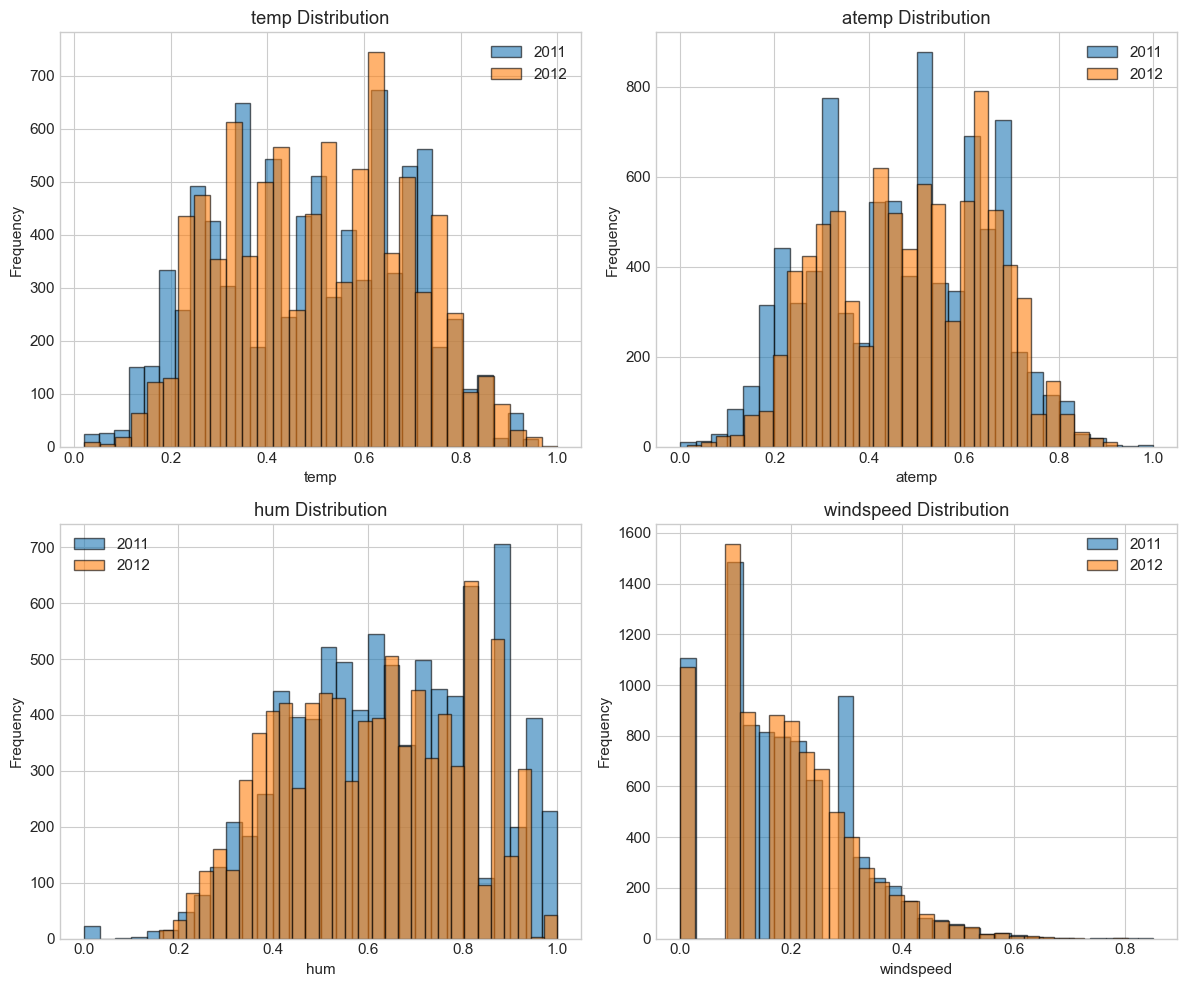

In [9]:
weather_features = ['temp', 'atemp', 'hum', 'windspeed']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(weather_features):
    axes[i].hist(train_2011[feature], bins=30, alpha=0.6, label='2011', edgecolor='black')
    axes[i].hist(eval_2012[feature], bins=30, alpha=0.6, label='2012', edgecolor='black')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'{feature} Distribution')
    axes[i].legend()

plt.tight_layout()
plt.show()

### 2.6 Weather Impact on Rentals

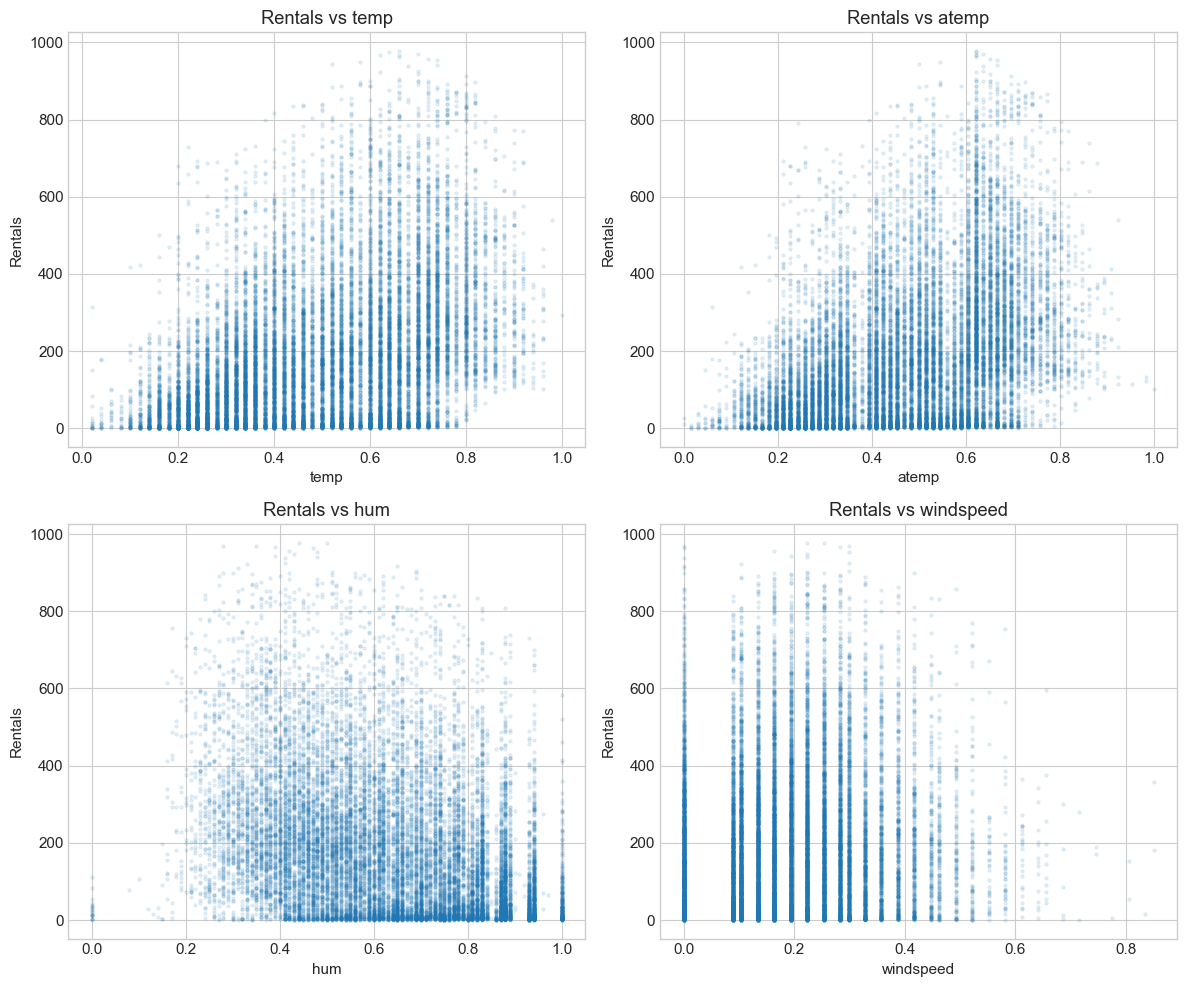

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, feature in enumerate(weather_features):
    axes[i].scatter(df[feature], df['cnt'], alpha=0.1, s=5)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Rentals')
    axes[i].set_title(f'Rentals vs {feature}')

plt.tight_layout()
plt.show()

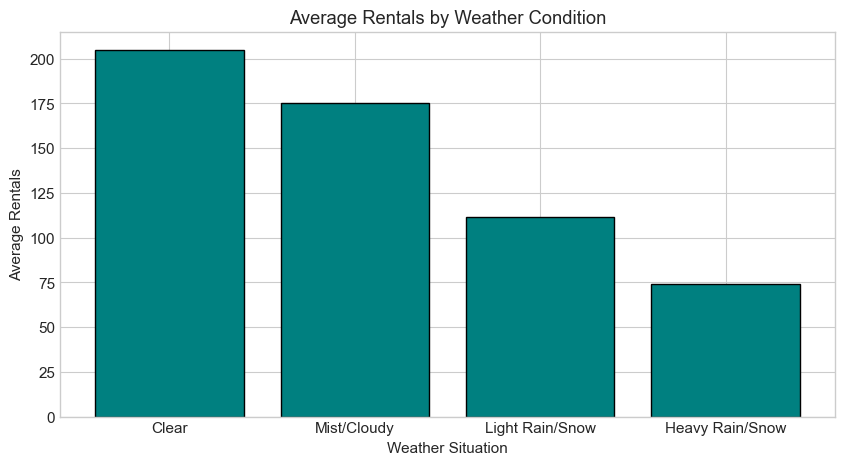

In [11]:
# Weather situation impact
weather_labels = ['Clear', 'Mist/Cloudy', 'Light Rain/Snow', 'Heavy Rain/Snow']
weather_avg = df.groupby('weathersit')['cnt'].mean()

plt.figure(figsize=(10, 5))
plt.bar(weather_labels[:len(weather_avg)], weather_avg.values, color='teal', edgecolor='black')
plt.xlabel('Weather Situation')
plt.ylabel('Average Rentals')
plt.title('Average Rentals by Weather Condition')
plt.show()

### 2.7 Feature Correlations

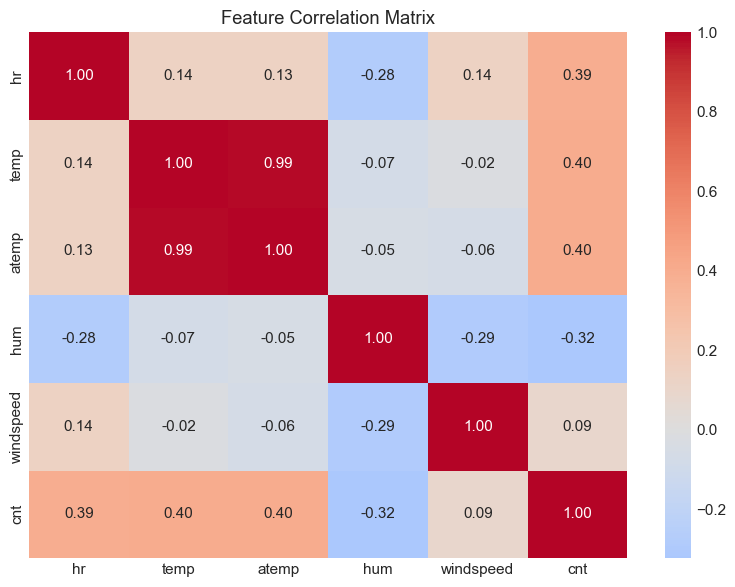

In [12]:
# Correlation matrix for numeric features
corr_cols = ['hr', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']
corr_matrix = df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 3. Baseline Model Training

We'll train a Random Forest regressor on 2011 data to predict rental counts.

In [13]:
# Prepare features and target
feature_cols = [
    'season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
    'weathersit', 'temp', 'atemp', 'hum', 'windspeed'
]
target_col = 'cnt'

print(f"Features: {feature_cols}")
print(f"Target: {target_col}")

X_train = train_2011[feature_cols]
y_train = train_2011[target_col]

X_test = eval_2012[feature_cols]
y_test = eval_2012[target_col]

print(f"\nTraining samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

Features: ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
Target: cnt

Training samples: 8,645
Test samples: 8,734


In [14]:
# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)
print("Training complete!")

Training Random Forest...
Training complete!


## 4. Model Evaluation

In [15]:
# Predictions on training and test sets
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Calculate metrics
def calculate_metrics(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE:  {mae:.2f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'rmse': rmse, 'mae': mae, 'r2': r2}

train_metrics = calculate_metrics(y_train, y_train_pred, "Training (2011)")
test_metrics = calculate_metrics(y_test, y_test_pred, "Test (2012)")

print(f"\n{'='*50}")
print(f"BASELINE RMSE on 2012 data: {test_metrics['rmse']:.2f}")
print(f"{'='*50}")


Training (2011) Metrics:
  RMSE: 20.09
  MAE:  12.01
  R²:   0.9775

Test (2012) Metrics:
  RMSE: 125.66
  MAE:  89.10
  R²:   0.6382

BASELINE RMSE on 2012 data: 125.66


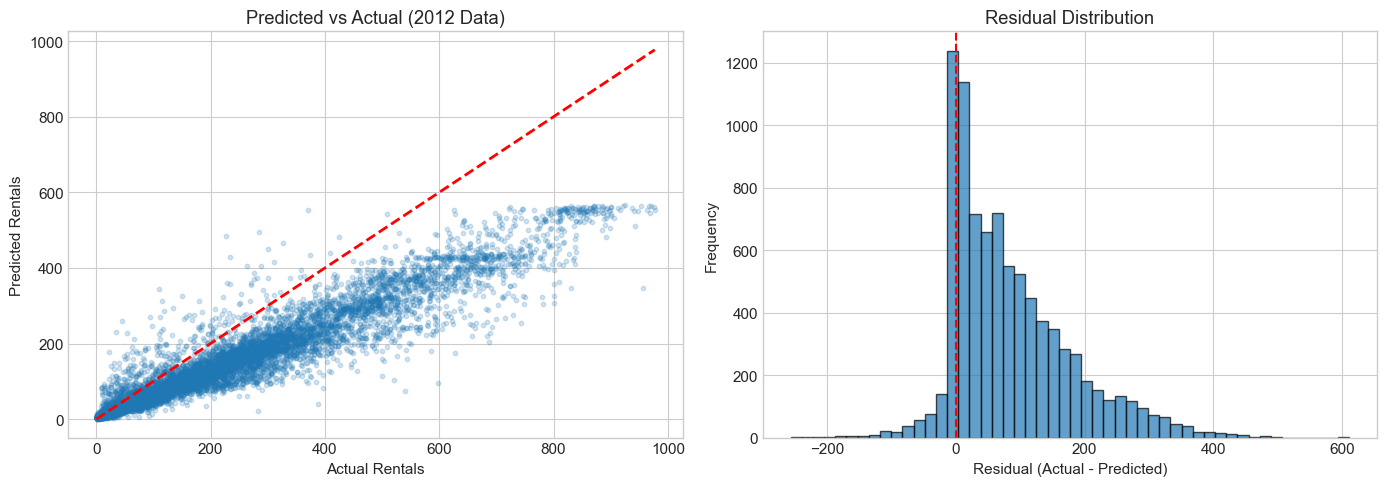

In [16]:
# Visualize predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, y_test_pred, alpha=0.2, s=10)
axes[0].plot([0, y_test.max()], [0, y_test.max()], 'r--', linewidth=2)
axes[0].set_xlabel('Actual Rentals')
axes[0].set_ylabel('Predicted Rentals')
axes[0].set_title('Predicted vs Actual (2012 Data)')

# Residuals distribution
residuals = y_test - y_test_pred
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

### 4.1 Feature Importance

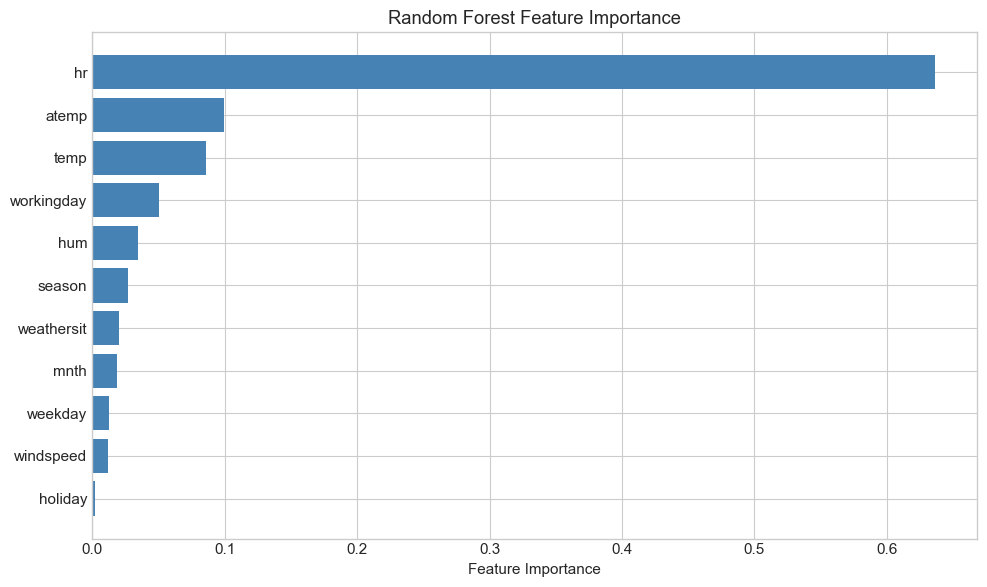


Feature Importance Ranking:
  hr          : 0.6362
  atemp       : 0.0993
  temp        : 0.0858
  workingday  : 0.0508
  hum         : 0.0344
  season      : 0.0270
  weathersit  : 0.0201
  mnth        : 0.0188
  weekday     : 0.0129
  windspeed   : 0.0124
  holiday     : 0.0024


In [17]:
# Feature importance from Random Forest
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['feature'], importance_df['importance'], color='steelblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for _, row in importance_df.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']:12s}: {row['importance']:.4f}")

### 4.2 Error Analysis by Time

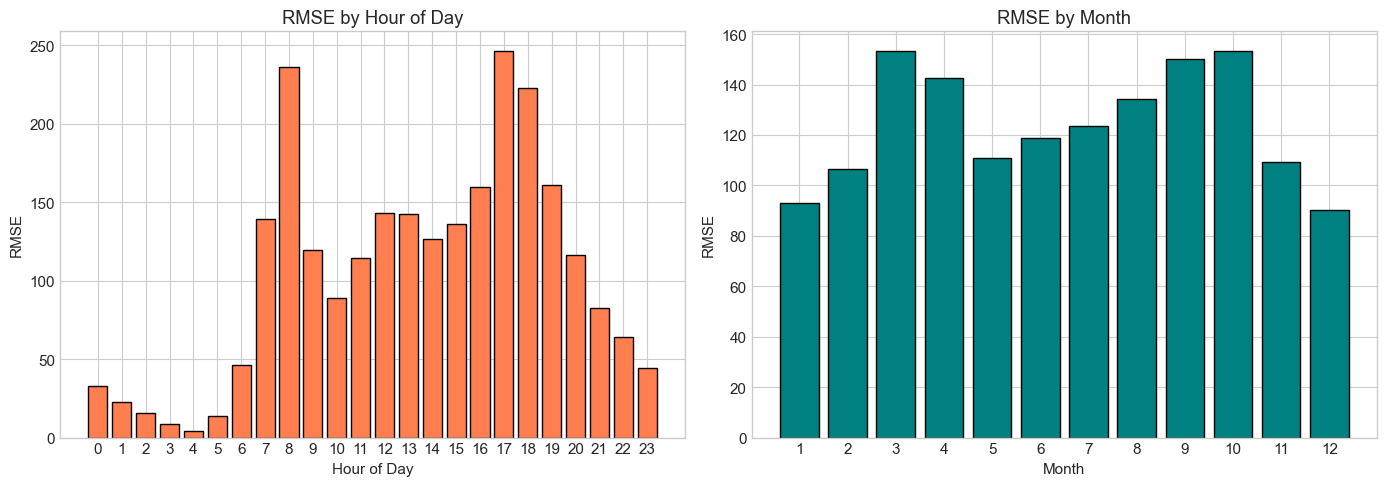

In [18]:
# Add predictions and errors to the test set
eval_2012_analysis = eval_2012.copy()
eval_2012_analysis['predicted'] = y_test_pred
eval_2012_analysis['error'] = eval_2012_analysis['cnt'] - eval_2012_analysis['predicted']
eval_2012_analysis['abs_error'] = np.abs(eval_2012_analysis['error'])

# RMSE by hour
hourly_rmse = eval_2012_analysis.groupby('hr').apply(
    lambda x: np.sqrt(mean_squared_error(x['cnt'], x['predicted'])),
    include_groups=False
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(hourly_rmse.index, hourly_rmse.values, color='coral', edgecolor='black')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE by Hour of Day')
axes[0].set_xticks(range(0, 24))

# RMSE by month
monthly_rmse = eval_2012_analysis.groupby('mnth').apply(
    lambda x: np.sqrt(mean_squared_error(x['cnt'], x['predicted'])),
    include_groups=False
)

axes[1].bar(monthly_rmse.index, monthly_rmse.values, color='teal', edgecolor='black')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('RMSE')
axes[1].set_title('RMSE by Month')
axes[1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

## 5. Summary

### Key Findings from EDA:
- Clear bimodal pattern on working days (8am and 5-6pm commute peaks)
- Weekend usage is more uniform throughout the day
- Ridership higher in summer/fall than winter
- 2012 has ~65% higher average ridership than 2011 (system growth)
- Temperature positively correlated with rentals; humidity negatively correlated

### Baseline Model:
- Random Forest trained on 2011 data
- Hour is the most important feature, followed by temperature
- Baseline RMSE on 2012 captures the model's performance before any drift injection

In [19]:
# Save key values for use in other notebooks
baseline_results = {
    'train_rmse': train_metrics['rmse'],
    'test_rmse': test_metrics['rmse'],
    'train_r2': train_metrics['r2'],
    'test_r2': test_metrics['r2'],
    'feature_importance': dict(zip(feature_cols, rf_model.feature_importances_)),
    'train_size': len(train_2011),
    'test_size': len(eval_2012)
}

print("Baseline Results Summary:")
for key, value in baseline_results.items():
    if key != 'feature_importance':
        print(f"  {key}: {value}")

Baseline Results Summary:
  train_rmse: 20.088547821540494
  test_rmse: 125.65987732390016
  train_r2: 0.9774550628268883
  test_r2: 0.6381566298249334
  train_size: 8645
  test_size: 8734
